# Working with HTML Pages

## Parsing XML and HTML

In [1]:
from lxml import objectify
import pandas as pd
from distutils import util
xml = objectify.parse(open('XMLData.xml'))
root = xml.getroot()
df = pd.DataFrame(columns=('Number', 'Boolean'))
for i in range(0, 4):
    obj = root.getchildren()[i].getchildren()
    row = dict(zip(['Number', 'Boolean'],
                   [obj[0].pyval,
                   bool(util.strtobool(obj[2].text))]))
    row_s = pd.Series(row)
    row_s.name = obj[1].text
    df = df.append(row_s)
    
print(type(df.loc['First']['Number']))
print(type(df.loc['First']['Boolean']))

<class 'int'>
<class 'bool'>


## Using XPath for data extraction

In [2]:
from lxml import objectify
import pandas as pd
from distutils import util

xml = objectify.parse(open('XMLData.xml'))
root = xml.getroot()
map_number = map(int, root.xpath('Record/Number'))
map_bool = map(str, root.xpath('Record/Boolean'))
map_bool = map(util.strtobool, map_bool)
map_bool = map(bool, map_bool)
map_string = map(str, root.xpath('Record/String'))

data = list(zip(map_number, map_bool))
df = pd.DataFrame(data, 
                  columns=('Number', 'Boolean'), 
                  index = list(map_string))

print(df)
print(type(df.loc['First']['Number']))
print(type(df.loc['First']['Boolean']))

        Number  Boolean
First        1     True
Second       2    False
Third        3     True
Fourth       4    False
<class 'numpy.int64'>
<class 'numpy.bool_'>


# Working with Raw Text

## Stemming and removing stop words

In [3]:
from sklearn.feature_extraction.text import *
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

vocab = ['Sam loves swimming so he swims all the time']
vect = CountVectorizer(tokenizer=tokenize,
                       stop_words='english')
vec = vect.fit(vocab)

sentence1 = vec.transform(['George loves swimming too!'])

print(vec.get_feature_names_out())
print(sentence1.toarray())

['love' 'sam' 'swim' 'time']
[[1 0 1 0]]


/Users/chrisminnick/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/chrisminnick/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', '

## Introducing regular expressions

In [4]:
import re

data1 = 'My phone number is: 800-555-1212.'
data2 = '800-555-1234 is my phone number.'

pattern = re.compile(r'(\d{3})-(\d{3})-(\d{4})')

dmatch1 = pattern.search(data1).groups()
dmatch2 = pattern.search(data2).groups()

print(dmatch1)
print(dmatch2)

('800', '555', '1212')
('800', '555', '1234')


# Using the Bag of Words Model and Beyond

## Understanding the bag of words model

In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import *

categories = ['comp.graphics', 'misc.forsale',
              'rec.autos', 'sci.space']
twenty_train = fetch_20newsgroups(subset='train',
    categories=categories,
    shuffle=True,
    random_state=42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(
    twenty_train.data)

print("BOW shape:", X_train_counts.shape)
caltech_idx = count_vect.vocabulary_['caltech']
print('"Caltech": %i' % X_train_counts[0, caltech_idx])

BOW shape: (2356, 34750)
"Caltech": 3


## Working with n-grams

In [12]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import *

categories = ['sci.space']

twenty_train = fetch_20newsgroups(subset='train',
    categories=categories,
    remove=('headers','footers','quotes'),
    shuffle=True,
    random_state=42)

count_chars = CountVectorizer(analyzer='char_wb',
    ngram_range=(3,3),
    max_features=10)
count_chars.fit(twenty_train['data'])

count_words = CountVectorizer(analyzer='word',
    ngram_range=(2,2),
    max_features=10,
    stop_words='english')
count_words.fit(twenty_train['data'])

X = count_chars.transform(twenty_train.data)

print(count_chars.get_feature_names_out())
print(X[1].todense())
print(count_words.get_feature_names_out())

[' an' ' in' ' of' ' th' ' to' 'he ' 'ing' 'ion' 'nd ' 'the']
[[0 0 2 5 1 4 2 2 0 5]]
['anonymous ftp' 'commercial space' 'gamma ray' 'nasa gov'
 'national space' 'remote sensing' 'sci space' 'space shuttle'
 'space station' 'washington dc']


## Implementing TF-IDF transformations

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import *
categories = ['comp.graphics', 'misc.forsale',
              'rec.autos', 'sci.space']
twenty_train = fetch_20newsgroups(subset='train', 
                                  categories=categories,
                                  shuffle=True,
                                  random_state=42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
tfidf = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf.transform(X_train_counts)
caltech_idx = count_vect.vocabulary_['caltech']

print('"Caltech" scored in a BOW:')
print('count: %0.3f' % X_train_counts[0, caltech_idx])
print('TF-IDF: %0.3f' % X_train_tfidf[0, caltech_idx])

"Caltech" scored in a BOW:
count: 3.000
TF-IDF: 0.123


## Computing the mean word count and TF-IDF

In [8]:
import numpy as np
count = np.mean(X_train_counts[X_train_counts>0])
tfif = np.mean(X_train_tfidf[X_train_tfidf>0])
print('mean count: %0.3f' % np.mean(count))
print('mean TF-IDF: %0.3f' % np.mean(tfif))


mean count: 1.698
mean TF-IDF: 0.064


# Working with Graph Data

## Using NetworkX basics

### Creating the initial graph

In [9]:
import networkx as nx
G = nx.cycle_graph(10)
A = nx.adjacency_matrix(G)

print(A.todense())

[[0 1 0 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 0 1 0]]


### Visualizing the graph

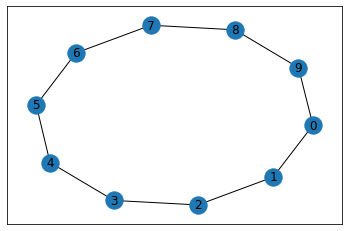

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw_networkx(G)
plt.show()

### Adding to the Graph

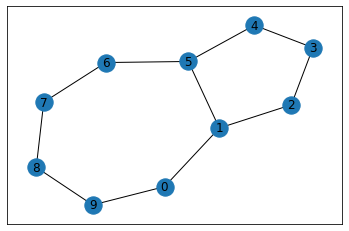

In [11]:
G.add_edge(1,5)
nx.draw_networkx(G)
plt.show()